To do:
1. Define GP inference function for Sphere/3d
2. Export various data sets in 3d

In [1]:
#Libraries:
#Tensors:
import torch
import numpy as np

#Plotting in 2d/3d:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
from matplotlib.colors import Normalize
import matplotlib.cm as cm
%matplotlib inline

#Tools:
from itertools import product, combinations
import sys
import math
from numpy import savetxt
import csv
import os 

sys.path.append("../..")
import Kernel_and_GP_tools as GP
import My_Tools
import Tasks.GP_div_free_small.loader as GP_load_data


In [2]:
Dataset=GP_load_data.give_GP_div_free_data_set(2,50,None,data_set='train',path_to_folder='')
GP_parameters={'l_scale':0.5,
'sigma_var': 2., 
'kernel_type':"div_free",
'obs_noise':1e-4}

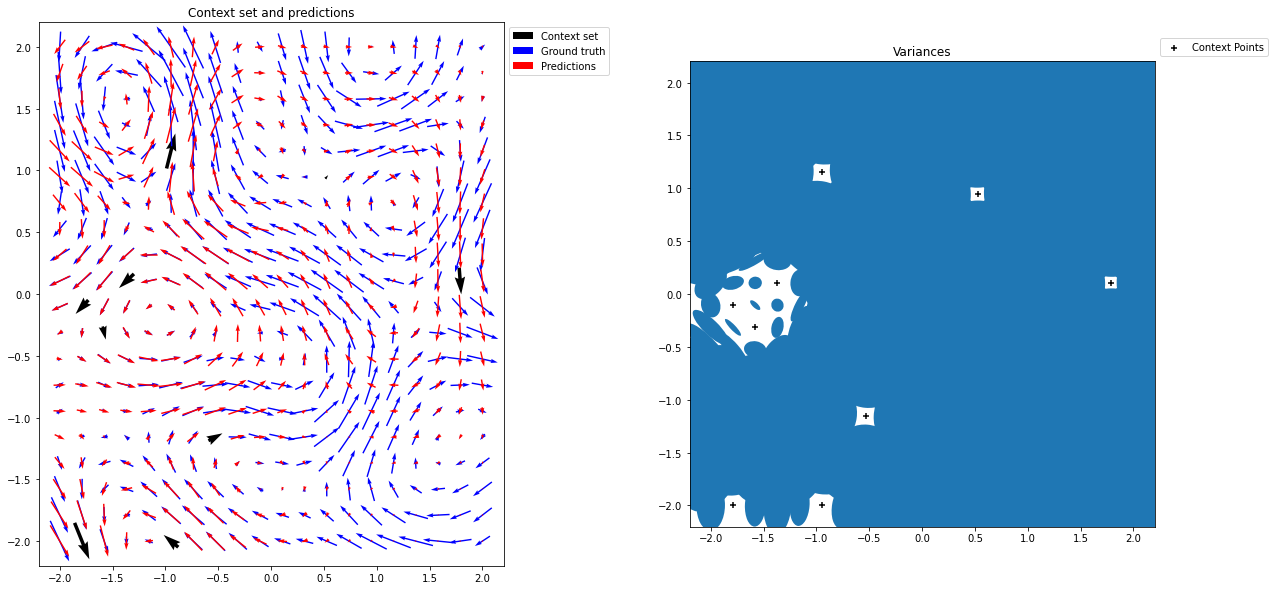

In [3]:
X_c,Y_c,X_t,Y_t=Dataset.get_rand_batch(batch_size=1)
Means,Covs,Vars=GP.GP_inference(X_c[0],Y_c[0],X_t[0],**GP_parameters)
Covs=My_Tools.Get_Block_Diagonal(Covs,size=2)
My_Tools.Plot_Inference_2d(X_c[0],Y_c[0],X_t[0],Y_t[0],Predict=Means,Cov_Mat=Covs,size_scale=2,quiver_scale=40)